In [1]:
import pandas as pd
classes_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edgelist_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_features.csv")

# GCN with Temporal Pseudo-Labeling (Self-Training)

This notebook implements a GCN pipeline using semi-supervised learning with pseudo-labeling. This notebook implements a confident thresholding mechanic, where all nodes above the specified confidence threshold is accepted. The model uses an expanding window strategy to iteratively:
1. Train on labeled + pseudo-labeled nodes
2. Predict on the next time window
3. Generate high-confidence pseudo-labels from unknown nodes
4. Add pseudo-labels to training set for next iteration

This approach leverages the large number of unlabeled nodes (77%) in the Elliptic dataset.

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, mean_squared_error
import time

/Users/nganjihin/Desktop/NUS/BT4012/Final Proj/elliptic/bt4012_elliptic/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Prepare node features
features = features_df.iloc[:, 1:].values
node_ids = features_df.iloc[:, 0].values

# Create node ID to index mapping
node_id_to_idx = {node_id: idx for idx, node_id in enumerate(node_ids)}

# Prepare labels - CORRECT MAPPING: '1'=illicit, '2'=licit
# Map to: 0=unknown, 1=illicit, 2=licit
classes_df['class'] = classes_df['class'].map({'unknown': 0, '1': 1, '2': 2})
labels = np.zeros(len(node_ids), dtype=int)
for _, row in classes_df.iterrows():
    if row['txId'] in node_id_to_idx:
        labels[node_id_to_idx[row['txId']]] = row['class']

# Prepare edge index
edge_list = []
for _, row in edgelist_df.iterrows():
    if row['txId1'] in node_id_to_idx and row['txId2'] in node_id_to_idx:
        edge_list.append([node_id_to_idx[row['txId1']], node_id_to_idx[row['txId2']]])

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

# Convert to PyTorch tensors
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

print(f"Number of nodes: {x.shape[0]}")
print(f"Number of features: {x.shape[1]}")
print(f"Number of edges: {edge_index.shape[1]}")
print(f"Label distribution: Unknown={sum(y==0)}, Illicit={sum(y==1)}, Licit={sum(y==2)}")

Number of nodes: 203768
Number of features: 166
Number of edges: 234353
Label distribution: Unknown=157204, Illicit=4545, Licit=42019


In [4]:
# Define GCN model
class GCNFraudDetector(torch.nn.Module):
    def __init__(self, in_features=166, hidden=64, out_classes=3, dropout=0.5):
        super().__init__()
        self.gcn1 = GCNConv(in_features, hidden)
        self.gcn2 = GCNConv(hidden, hidden // 2)
        self.fc = torch.nn.Linear(hidden // 2, out_classes)
        self.dropout = dropout
    
    def forward(self, x, edge_index):
        # GCN Layer 1
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # GCN Layer 2
        x = self.gcn2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Output layer
        x = self.fc(x)
        return x
    
print("GCN Model Architecture defined")

GCN Model Architecture defined


# Temporal Pseudo-Labeling (Self-Training)

This section implements semi-supervised learning with pseudo-labeling using an expanding window strategy. The model iteratively:
1. Trains on labeled + pseudo-labeled nodes
2. Predicts on test window
3. Generates high-confidence pseudo-labels from unknown nodes
4. Adds pseudo-labels to training set for next iteration

In [5]:
# Extract time steps from features (column 1, 0-indexed)
time_steps = features_df.iloc[:, 1].values
time_steps_tensor = torch.tensor(time_steps, dtype=torch.long)

print(f"Time step range: {time_steps.min()} to {time_steps.max()}")
print(f"Unique time steps: {len(np.unique(time_steps))}")

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move data to device
x = x.to(device)
edge_index = edge_index.to(device)
y = y.to(device)

print(f"Using device: {device}")

Time step range: 1 to 49
Unique time steps: 49
Using device: cpu


In [6]:
# Define temporal windows (expanding window strategy)
# Train on t=1 to train_end, test on test_start to test_end
windows = [
    (1, 10, 11, 15),
    (1, 15, 16, 20),
    (1, 20, 21, 25),
    (1, 25, 26, 30),
    (1, 30, 31, 35),
    (1, 35, 36, 40),
    (1, 40, 41, 45),
    (1, 45, 46, 49),
]

# Hyperparameters
CONFIDENCE_THRESHOLD = 0.98
NUM_EPOCHS = 50
LEARNING_RATE = 0.01

print(f"Number of windows: {len(windows)}")
print(f"Confidence threshold: {CONFIDENCE_THRESHOLD}")
print(f"Epochs per window: {NUM_EPOCHS}")

Number of windows: 8
Confidence threshold: 0.98
Epochs per window: 50


In [7]:
def compute_class_weights(labels, device):
    """Compute balanced class weights for illicit/licit classes."""
    n_illicit = (labels == 1).sum().float()
    n_licit = (labels == 2).sum().float()
    total = len(labels)
    
    if n_illicit == 0 or n_licit == 0:
        return torch.tensor([1.0, 1.0, 1.0], dtype=torch.float).to(device)
    
    weight_illicit = total / (2.0 * n_illicit)
    weight_licit = total / (2.0 * n_licit)
    
    return torch.tensor([1.0, weight_illicit, weight_licit], dtype=torch.float).to(device)


def train_model(model, x, edge_index, y, train_mask, num_epochs, lr, device):
    """Train model on given mask."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    class_weights = compute_class_weights(y[train_mask], device)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        out = model(x, edge_index)
        loss = criterion(out[train_mask], y[train_mask])
        loss.backward()
        optimizer.step()
    
    return model


@torch.no_grad()
def evaluate(model, x, edge_index, y, test_mask):
    """Evaluate model and return metrics."""
    model.eval()
    out = model(x, edge_index)
    probs = F.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    
    # Get test predictions
    test_pred = pred[test_mask].cpu().numpy()
    test_labels = y[test_mask].cpu().numpy()
    test_probs = probs[test_mask][:, 1].cpu().numpy()
    
    # Binary conversion (illicit=1, licit=0)
    binary_pred = (test_pred == 1).astype(int)
    binary_labels = (test_labels == 1).astype(int)
    
    metrics = {
        'accuracy': accuracy_score(binary_labels, binary_pred),
        'precision': precision_score(binary_labels, binary_pred, zero_division=0),
        'recall': recall_score(binary_labels, binary_pred, zero_division=0),
        'f1': f1_score(binary_labels, binary_pred, zero_division=0),
        'auc_roc': roc_auc_score(binary_labels, test_probs) if len(np.unique(binary_labels)) > 1 else 0,
        'pr_auc': average_precision_score(binary_labels, test_probs) if len(np.unique(binary_labels)) > 1 else 0,
    }
    
    return metrics


@torch.no_grad()
def generate_pseudo_labels(model, x, edge_index, unknown_mask, threshold):
    """Generate pseudo-labels for unknown nodes above confidence threshold."""
    model.eval()
    out = model(x, edge_index)
    probs = F.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    
    # Get confidence (max probability)
    confidence, _ = probs.max(dim=1)
    
    # Select high-confidence predictions on unknown nodes
    # Only consider illicit (1) or licit (2) predictions, not unknown (0)
    confident_mask = (
        unknown_mask & 
        (confidence >= threshold) & 
        (pred > 0)  # Exclude class 0 predictions
    )
    
    indices = torch.where(confident_mask)[0]
    labels = pred[confident_mask]
    confs = confidence[confident_mask]
    
    return indices, labels, confs


print("Helper functions defined")

Helper functions defined


In [8]:
# Main training loop with pseudo-labeling
print("=" * 60)
print("TEMPORAL PSEUDO-LABELING TRAINING")
print("=" * 60)

# Store pseudo-labels: {node_idx: label}
pseudo_labels = {}

# Store results for each window
all_results = []

# Create working copy of labels (will be modified with pseudo-labels)
y_with_pseudo = y.clone()

# Start time
start_time = time.perf_counter()

for window_idx, (train_start, train_end, test_start, test_end) in enumerate(windows):
    print(f"\n{'='*60}")
    print(f"Window {window_idx + 1}: Train t={train_start}-{train_end}, Test t={test_start}-{test_end}")
    print("=" * 60)
    
    # ----- Step 1: Create masks -----
    # Labeled nodes in training window
    train_mask_labeled = (
        (time_steps_tensor >= train_start) & 
        (time_steps_tensor <= train_end) & 
        (y > 0)
    )
    
    # Pseudo-labeled nodes in training window
    pseudo_indices = torch.tensor(list(pseudo_labels.keys()), dtype=torch.long)
    train_mask_pseudo = torch.zeros(len(y), dtype=torch.bool)
    if len(pseudo_indices) > 0:
        # Only include pseudo-labels within current training window
        for idx in pseudo_indices:
            if time_steps_tensor[idx] <= train_end:
                train_mask_pseudo[idx] = True
    
    # Combined training mask
    train_mask = train_mask_labeled | train_mask_pseudo
    
    # Test mask (only labeled nodes in test window)
    test_mask = (
        (time_steps_tensor >= test_start) & 
        (time_steps_tensor <= test_end) & 
        (y > 0)
    )
    
    # Count samples
    n_labeled = train_mask_labeled.sum().item()
    n_pseudo = train_mask_pseudo.sum().item()
    n_test = test_mask.sum().item()
    
    print(f"Training: {n_labeled} labeled + {n_pseudo} pseudo = {n_labeled + n_pseudo} total")
    print(f"Testing:  {n_test} nodes")
    
    # ----- Step 2: Train model -----
    model = GCNFraudDetector(
        in_features=x.shape[1], 
        hidden=64, 
        out_classes=3, 
        dropout=0.5
    ).to(device)
    
    model = train_model(
        model, x, edge_index, y_with_pseudo, 
        train_mask, NUM_EPOCHS, LEARNING_RATE, device
    )
    
    # ----- Step 3: Evaluate on test window -----
    metrics = evaluate(model, x, edge_index, y, test_mask)
    metrics['window'] = window_idx + 1
    metrics['train_end'] = train_end
    metrics['n_pseudo'] = n_pseudo
    
    print(f"\nTest Metrics:")
    print(f"  Accuracy:  {metrics['accuracy']*100:.2f}%")
    print(f"  Precision: {metrics['precision']*100:.2f}%")
    print(f"  Recall:    {metrics['recall']*100:.2f}%")
    print(f"  F1 Score:  {metrics['f1']*100:.2f}%")
    print(f"  AUC-ROC:   {metrics['auc_roc']:.4f}")
    print(f"  PR-AUC:   {metrics['pr_auc']:.4f}")
    
    # ----- Step 4: Generate pseudo-labels -----
    # Unknown nodes in training window
    unknown_mask = (
        (time_steps_tensor >= train_start) & 
        (time_steps_tensor <= train_end) & 
        (y == 0)
    ).to(device)
    
    indices, labels, confs = generate_pseudo_labels(
        model, x, edge_index, unknown_mask, CONFIDENCE_THRESHOLD
    )
    
    # Calculate average confidence of pseudo-labeled nodes
    if len(confs) > 0:
        avg_pseudo_confidence = confs.mean().item()
    else:
        avg_pseudo_confidence = 0.0
    
    metrics['avg_pseudo_confidence'] = avg_pseudo_confidence
    all_results.append(metrics)
    
    # Add new pseudo-labels
    new_pseudo = 0
    for idx, label, conf in zip(indices.cpu().numpy(), labels.cpu().numpy(), confs.cpu().numpy()):
        if idx not in pseudo_labels:
            pseudo_labels[idx] = label
            y_with_pseudo[idx] = label
            new_pseudo += 1
    
    # Count pseudo-labels by class
    pseudo_illicit = sum(1 for l in pseudo_labels.values() if l == 1)
    pseudo_licit = sum(1 for l in pseudo_labels.values() if l == 2)
    
    print(f"\nPseudo-labels:")
    print(f"  New this window: {new_pseudo}")
    print(f"  Avg Confidence:  {avg_pseudo_confidence:.4f}")
    print(f"  Total accumulated: {len(pseudo_labels)} (Illicit: {pseudo_illicit}, Licit: {pseudo_licit})")

end_time = time.perf_counter()
elapsed_time = end_time - start_time
print("\n" + "=" * 60)
print(f"TRAINING COMPLETED IN {elapsed_time:.3f} SECONDS")
print("=" * 60)


TEMPORAL PSEUDO-LABELING TRAINING

Window 1: Train t=1-10, Test t=11-15
Training: 12468 labeled + 0 pseudo = 12468 total
Testing:  3046 nodes

Test Metrics:
  Accuracy:  73.60%
  Precision: 43.62%
  Recall:    95.86%
  F1 Score:  59.96%
  AUC-ROC:   0.9359
  PR-AUC:   0.7683

Pseudo-labels:
  New this window: 16294
  Avg Confidence:  0.9963
  Total accumulated: 16294 (Illicit: 889, Licit: 15405)

Window 2: Train t=1-15, Test t=16-20
Training: 15514 labeled + 16294 pseudo = 31808 total
Testing:  3375 nodes

Test Metrics:
  Accuracy:  67.94%
  Precision: 35.96%
  Recall:    95.80%
  F1 Score:  52.29%
  AUC-ROC:   0.9062
  PR-AUC:   0.6406

Pseudo-labels:
  New this window: 8531
  Avg Confidence:  0.9963
  Total accumulated: 24825 (Illicit: 2609, Licit: 22216)

Window 3: Train t=1-20, Test t=21-25
Training: 18889 labeled + 24825 pseudo = 43714 total
Testing:  5311 nodes

Test Metrics:
  Accuracy:  75.71%
  Precision: 27.54%
  Recall:    78.45%
  F1 Score:  40.77%
  AUC-ROC:   0.8578
  PR-

In [9]:
# Summary of results across all windows
import matplotlib.pyplot as plt

results_df = pd.DataFrame(all_results)

print("\n" + "=" * 60)
print("RESULTS SUMMARY")
print("=" * 60)
print(results_df[['window', 'train_end', 'n_pseudo', 'accuracy', 'precision', 'recall', 'f1', 'auc_roc', 'avg_pseudo_confidence']].to_string(index=False))

print(f"\nAverage across all windows:")
print(f"  Accuracy:              {results_df['accuracy'].mean()*100:.2f}%")
print(f"  Precision:             {results_df['precision'].mean()*100:.2f}%")
print(f"  Recall:                {results_df['recall'].mean()*100:.2f}%")
print(f"  F1 Score:              {results_df['f1'].mean()*100:.2f}%")
print(f"  AUC-ROC:               {results_df['auc_roc'].mean():.4f}")
print(f"  Avg Pseudo Confidence: {results_df['avg_pseudo_confidence'].mean():.4f}")

# Original dataset statistics
total_nodes = len(y)
orig_unknown = (y == 0).sum().item()
orig_illicit = (y == 1).sum().item()
orig_licit = (y == 2).sum().item()
orig_labeled = orig_illicit + orig_licit

# After pseudo-labeling statistics
pseudo_illicit = sum(1 for l in pseudo_labels.values() if l == 1)
pseudo_licit = sum(1 for l in pseudo_labels.values() if l == 2)
new_unknown = orig_unknown - len(pseudo_labels)
new_illicit = orig_illicit + pseudo_illicit
new_licit = orig_licit + pseudo_licit
new_labeled = new_illicit + new_licit

print(f"\n" + "=" * 60)
print("DATASET STATISTICS")
print("=" * 60)

print(f"\nOriginal Dataset:")
print(f"  Unknown: {orig_unknown} ({orig_unknown/total_nodes*100:.1f}%)")
print(f"  Illicit: {orig_illicit} ({orig_illicit/total_nodes*100:.1f}%)")
print(f"  Licit:   {orig_licit} ({orig_licit/total_nodes*100:.1f}%)")
print(f"  Illicit:Licit ratio: 1:{orig_licit/orig_illicit:.1f}")

print(f"\nAfter Pseudo-Labeling:")
print(f"  Unknown: {new_unknown} ({new_unknown/total_nodes*100:.1f}%)")
print(f"  Illicit: {new_illicit} ({new_illicit/total_nodes*100:.1f}%)")
print(f"  Licit:   {new_licit} ({new_licit/total_nodes*100:.1f}%)")
print(f"  Illicit:Licit ratio: 1:{new_licit/new_illicit:.1f}")

print(f"\nPseudo-Labeling Impact:")
print(f"  Total pseudo-labels generated: {len(pseudo_labels)}")
print(f"    Illicit: {pseudo_illicit}")
print(f"    Licit:   {pseudo_licit}")
print(f"  Unknown labels reduced: {orig_unknown} -> {new_unknown}")
print(f"  Percentage decrease in unknown: {(orig_unknown - new_unknown)/orig_unknown*100:.1f}%")
print(f"  Labeled data increase: {orig_labeled} -> {new_labeled} ({(new_labeled - orig_labeled)/orig_labeled*100:.1f}% increase)")


RESULTS SUMMARY
 window  train_end  n_pseudo  accuracy  precision   recall       f1  auc_roc  avg_pseudo_confidence
      1         10         0  0.736047   0.436232 0.958599 0.599602 0.935876               0.996287
      2         15     16294  0.679407   0.359612 0.957997 0.522928 0.906205               0.996273
      3         20     24825  0.757108   0.275434 0.784452 0.407713 0.857785               0.996496
      4         25     32772  0.734196   0.460156 0.954619 0.620980 0.919646               0.996981
      5         30     38939  0.692610   0.332462 0.921739 0.488667 0.866998               0.996312
      6         35     42959  0.788088   0.199683 0.668435 0.307505 0.816632               0.996250
      7         40     46357  0.868104   0.203494 0.485294 0.286749 0.805304               0.996638
      8         45     48983  0.930938   0.098592 0.060345 0.074866 0.801466               0.996469

Average across all windows:
  Accuracy:              77.33%
  Precision:          

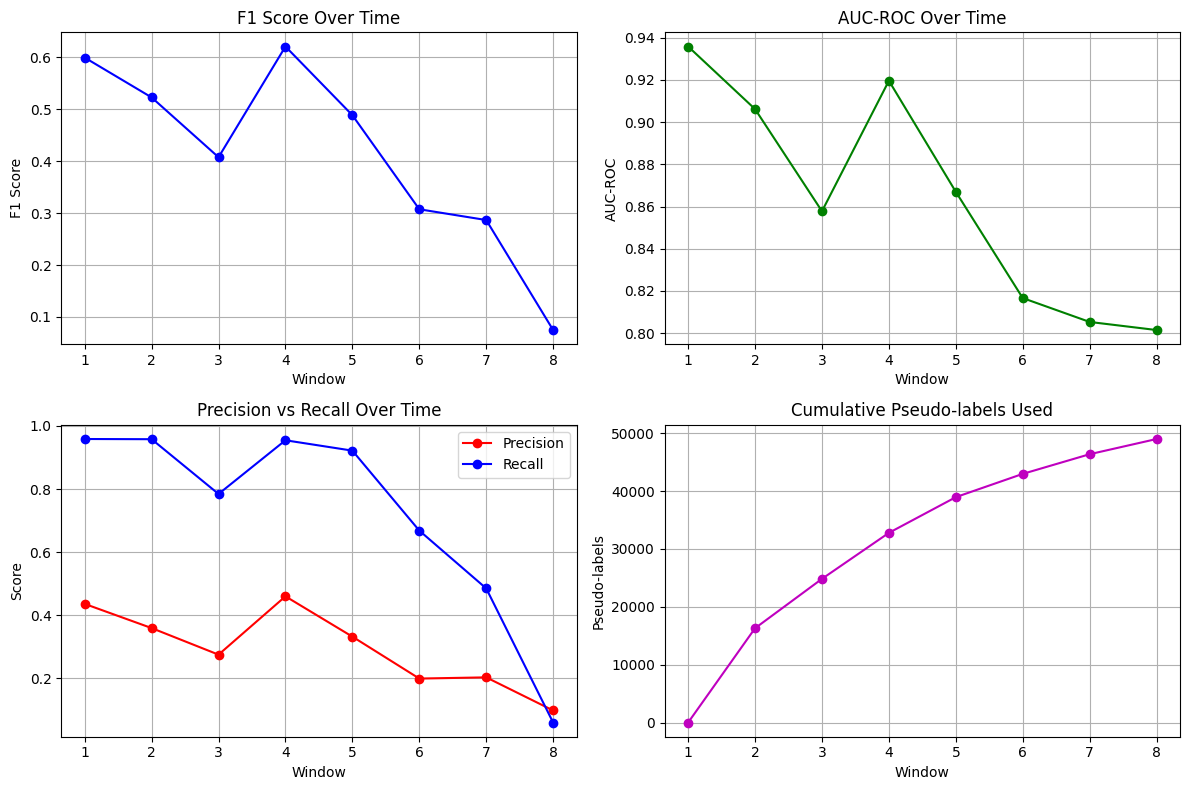

In [10]:
# Plot metrics over time
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# F1 Score
axes[0, 0].plot(results_df['window'], results_df['f1'], 'b-o')
axes[0, 0].set_xlabel('Window')
axes[0, 0].set_ylabel('F1 Score')
axes[0, 0].set_title('F1 Score Over Time')
axes[0, 0].grid(True)

# AUC-ROC
axes[0, 1].plot(results_df['window'], results_df['auc_roc'], 'g-o')
axes[0, 1].set_xlabel('Window')
axes[0, 1].set_ylabel('AUC-ROC')
axes[0, 1].set_title('AUC-ROC Over Time')
axes[0, 1].grid(True)

# Precision and Recall
axes[1, 0].plot(results_df['window'], results_df['precision'], 'r-o', label='Precision')
axes[1, 0].plot(results_df['window'], results_df['recall'], 'b-o', label='Recall')
axes[1, 0].set_xlabel('Window')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Precision vs Recall Over Time')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Pseudo-labels accumulated
axes[1, 1].plot(results_df['window'], results_df['n_pseudo'], 'm-o')
axes[1, 1].set_xlabel('Window')
axes[1, 1].set_ylabel('Pseudo-labels')
axes[1, 1].set_title('Cumulative Pseudo-labels Used')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Experiment: GCN with Pseudo-Labeled Dataset (Temporal Split 1-39)

Train a GCN model using the enriched dataset (original labels + pseudo-labels from window 8).
- Training: time steps 1-39
- Testing: time steps 40-49
- This evaluates whether the pseudo-labeled data improves model performance compared to using only original labels.

In [11]:
# Create temporal split masks using pseudo-labeled dataset
split_time_step = 39

# Training mask: labeled + pseudo-labeled nodes in time steps 1-39
train_mask_final = torch.zeros(len(y), dtype=torch.bool)
test_mask_final = torch.zeros(len(y), dtype=torch.bool)

for idx in range(len(y)):
    ts = time_steps[idx]
    # Check if node has a label (original or pseudo)
    has_label = (y_with_pseudo[idx] > 0).item()
    
    if has_label:
        if ts <= split_time_step:
            train_mask_final[idx] = True
        else:
            test_mask_final[idx] = True

# Move masks to device
train_mask_final = train_mask_final.to(device)
test_mask_final = test_mask_final.to(device)

print(f"Temporal Split (1-39 / 40-49) with Pseudo-Labeled Dataset")
print(f"=" * 60)
print(f"Training nodes: {train_mask_final.sum().item()}")
print(f"Test nodes:     {test_mask_final.sum().item()}")

# Class distribution in training set
train_labels_final = y_with_pseudo[train_mask_final]
n_illicit_train = (train_labels_final == 1).sum().item()
n_licit_train = (train_labels_final == 2).sum().item()

print(f"\nTraining set distribution:")
print(f"  Illicit: {n_illicit_train} ({n_illicit_train/(n_illicit_train+n_licit_train)*100:.1f}%)")
print(f"  Licit:   {n_licit_train} ({n_licit_train/(n_illicit_train+n_licit_train)*100:.1f}%)")

# Class distribution in test set (using original labels for evaluation)
test_labels_final = y[test_mask_final]
n_illicit_test = (test_labels_final == 1).sum().item()
n_licit_test = (test_labels_final == 2).sum().item()

print(f"\nTest set distribution (original labels):")
print(f"  Illicit: {n_illicit_test} ({n_illicit_test/(n_illicit_test+n_licit_test)*100:.1f}%)")
print(f"  Licit:   {n_licit_test} ({n_licit_test/(n_illicit_test+n_licit_test)*100:.1f}%)")

Temporal Split (1-39 / 40-49) with Pseudo-Labeled Dataset
Training nodes: 84989
Test nodes:     12752

Training set distribution:
  Illicit: 15104 (17.8%)
  Licit:   69885 (82.2%)

Test set distribution (original labels):
  Illicit: 636 (5.7%)
  Licit:   10548 (94.3%)


In [12]:
# Initialize model for final experiment
model_final = GCNFraudDetector(
    in_features=x.shape[1], 
    hidden=64, 
    out_classes=3, 
    dropout=0.5
).to(device)

# Calculate class weights for training set
class_weights_final = compute_class_weights(y_with_pseudo[train_mask_final], device)

print("Model class weights:")
print(f"  Class 0 (Unknown): {class_weights_final[0]:.4f}")
print(f"  Class 1 (Illicit): {class_weights_final[1]:.4f}")
print(f"  Class 2 (Licit):   {class_weights_final[2]:.4f}")
print(f"  Weight ratio (Illicit/Licit): {class_weights_final[1]/class_weights_final[2]:.2f}x")

optimizer_final = torch.optim.Adam(model_final.parameters(), lr=0.01)
criterion_final = torch.nn.CrossEntropyLoss(weight=class_weights_final)

Model class weights:
  Class 0 (Unknown): 1.0000
  Class 1 (Illicit): 2.8135
  Class 2 (Licit):   0.6081
  Weight ratio (Illicit/Licit): 4.63x


In [13]:
# Training functions for final model
def train_final():
    model_final.train()
    optimizer_final.zero_grad()
    out = model_final(x, edge_index)
    loss = criterion_final(out[train_mask_final], y_with_pseudo[train_mask_final])
    loss.backward()
    optimizer_final.step()
    return loss.item()

@torch.no_grad()
def test_final(mask):
    model_final.eval()
    out = model_final(x, edge_index)
    pred = out.argmax(dim=1)
    # Evaluate against original labels
    correct = pred[mask] == y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc, pred[mask].cpu(), out[mask].cpu()

# Training loop
print("Training GCN with Pseudo-Labeled Dataset (Temporal Split 1-39)...")
print("=" * 60)

for epoch in range(1, 51):
    loss = train_final()
    
    if epoch % 10 == 0:
        train_acc, _, _ = test_final(train_mask_final)
        test_acc, _, _ = test_final(test_mask_final)
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

print("\nTraining completed!")

Training GCN with Pseudo-Labeled Dataset (Temporal Split 1-39)...
Epoch 010, Loss: 0.3361, Train Acc: 0.3133, Test Acc: 0.3428
Epoch 020, Loss: 0.2453, Train Acc: 0.3463, Test Acc: 0.6354
Epoch 030, Loss: 0.2012, Train Acc: 0.3521, Test Acc: 0.7011
Epoch 040, Loss: 0.1778, Train Acc: 0.3633, Test Acc: 0.7415
Epoch 050, Loss: 0.1655, Train Acc: 0.3648, Test Acc: 0.7520

Training completed!


In [14]:
# Final evaluation
_, test_pred_final, test_out_final = test_final(test_mask_final)
test_labels_orig = y[test_mask_final].cpu().numpy()

# Convert to binary classification (illicit=1, licit=0)
binary_pred_final = (test_pred_final.numpy() == 1).astype(int)
binary_labels_final = (test_labels_orig == 1).astype(int)

# Calculate metrics
accuracy_final = accuracy_score(binary_labels_final, binary_pred_final)
precision_final = precision_score(binary_labels_final, binary_pred_final, zero_division=0)
recall_final = recall_score(binary_labels_final, binary_pred_final, zero_division=0)
f1_final = f1_score(binary_labels_final, binary_pred_final, zero_division=0)

# Get probabilities for AUC-ROC and PR-AUC
test_probs_final = F.softmax(test_out_final, dim=1)[:, 1].numpy()
auc_roc_final = roc_auc_score(binary_labels_final, test_probs_final)
pr_auc_final = average_precision_score(binary_labels_final, test_probs_final)

# RMSE
rmse_final = np.sqrt(mean_squared_error(binary_labels_final, binary_pred_final))

print("\n" + "=" * 60)
print("PSEUDO-LABELED DATASET - FINAL EVALUATION METRICS")
print("=" * 60)
print(f"Accuracy:  {accuracy_final*100:.2f}%")
print(f"Precision: {precision_final*100:.2f}%")
print(f"Recall:    {recall_final*100:.2f}%")
print(f"F1 Score:  {f1_final*100:.2f}%")
print(f"AUC-ROC:   {auc_roc_final:.4f}")
print(f"PR-AUC:    {pr_auc_final:.4f}")
print(f"RMSE:      {rmse_final:.4f}")
print("=" * 60)


PSEUDO-LABELED DATASET - FINAL EVALUATION METRICS
Accuracy:  84.39%
Precision: 14.33%
Recall:    42.77%
F1 Score:  21.47%
AUC-ROC:   0.7699
PR-AUC:    0.1174
RMSE:      0.3950


In [15]:
# Confusion matrix analysis
from sklearn.metrics import confusion_matrix

print("\n" + "=" * 60)
print("DIAGNOSTIC ANALYSIS")
print("=" * 60)

print("\n1. Test Set Class Distribution:")
print(f"   Illicit: {sum(binary_labels_final == 1)}")
print(f"   Licit:   {sum(binary_labels_final == 0)}")

print("\n2. Model Predictions:")
print(f"   Predicted Licit (0):   {sum(binary_pred_final == 0)}")
print(f"   Predicted Illicit (1): {sum(binary_pred_final == 1)}")

# Confusion matrix
cm_final = confusion_matrix(binary_labels_final, binary_pred_final)
print("\n3. Confusion Matrix (Licit=0, Illicit=1):")
print("   [[TN FP]")
print("    [FN TP]]")
print(f"   {cm_final}")
print(f"\n   True Negatives (correctly predicted Licit):   {cm_final[0,0]}")
print(f"   False Positives (Licit predicted as Illicit): {cm_final[0,1]}")
print(f"   False Negatives (Illicit predicted as Licit): {cm_final[1,0]}")
print(f"   True Positives (correctly predicted Illicit): {cm_final[1,1]}")

print("=" * 60)


DIAGNOSTIC ANALYSIS

1. Test Set Class Distribution:
   Illicit: 636
   Licit:   12116

2. Model Predictions:
   Predicted Licit (0):   10854
   Predicted Illicit (1): 1898

3. Confusion Matrix (Licit=0, Illicit=1):
   [[TN FP]
    [FN TP]]
   [[10490  1626]
 [  364   272]]

   True Negatives (correctly predicted Licit):   10490
   False Positives (Licit predicted as Illicit): 1626
   False Negatives (Illicit predicted as Licit): 364
   True Positives (correctly predicted Illicit): 272
